# Simulating Spiking Neural Networks

Building and simulating brain dynamics models is one of the important methods for studying brain dynamics. In spiking neural network simulations, we specify the model and input parameters, and conduct simulation experiments. During this process, parameter learning and updates (such as synaptic weights) are not involved. The main purpose is to simulate and analyze the designed network.

The spiking neural network models of brain dynamics can be divided into **single neuron models** and **neural network models**. We will demonstrate an example for each of these.

## Simulation of a Single Neuron Model

The **Hodgkin-Huxley (HH) model** is a mathematical model proposed in 1952 by neurophysiologists Allen Hodgkin (1914-1998) and Andrew Huxley (1917-2012) to describe the generation and propagation of action potentials in neurons. The HH model is based on the classical electrical circuit model and links the dynamic changes of the neuron membrane potential with the biophysical properties of the membrane ion channels. It is one of the most important theoretical models in neuroscience and earned the two researchers the Nobel Prize in Physiology or Medicine in 1963. The mathematical definition of the HH model is:

$$
\begin{aligned}C \frac {dV} {dt} = -(\bar{g}_{Na} m^3 h (V &-E_{Na}) + \bar{g}_K n^4 (V-E_K) + g_{leak} (V - E_{leak})) + I(t)\\
\frac {dx} {dt} &= \alpha_x (1-x)  - \beta_x, \quad x\in {\rm{\{m, h, n\}}}\\
&\alpha_m(V) = \frac {0.1(V+40)}{1-\exp(\frac{-(V + 40)} {10})}\\
&\beta_m(V) = 4.0 \exp(\frac{-(V + 65)} {18})\\
&\alpha_h(V) = 0.07 \exp(\frac{-(V+65)}{20})\\
&\beta_h(V) = \frac 1 {1 + \exp(\frac{-(V + 35)} {10})}\\
&\alpha_n(V) = \frac {0.01(V+55)}{1-\exp(-(V+55)/10)}\\
&\beta_n(V) = 0.125 \exp(\frac{-(V + 65)} {80})\end{aligned}
$$

In this tutorial, we simulate the HH model as an example of a single neuron model.``brainstate`` can run multiple neuron models in parallel, which saves time. We will simulate a group of HH neurons.

In [2]:
import brainunit as u
import jax.numpy as jnp
import matplotlib.pyplot as plt

import brainstate

In [3]:
# brainstate.environ.set(platform='gpu')

In [4]:
brainstate.random.seed(100)

## Defining the Single Neuron Model

We can use ``brainstate`` to define custom neuron models. To define a custom neuron model, we need to inherit the base class ``brainstate.nn.Dynamics``.

1. First, define the initialization method ``__init__()``. This method receives the number of neurons running in parallel, ``in_size``, and other model parameters. The base class is initialized with ``in_size``, and the model parameters are set as class attributes for easy access.

2. Then, we can define some common calculations as class methods for later use. Here, we implement functions related to the calculations of m, h, and n. Note that for the drift term function of an ordinary differential equation, the order of the incoming parameters should be, the dynamic variable, the current moment t and the other parameters.

3. Next, define the state initialization method ``init_state()``. Unlike ``__init__()``, this method initializes the model's state, not the model parameters. The state refers to variables that change during the model's operation. In ``brainstate``, all variables that need to change must be encapsulated in a ``State`` object. The hidden state variables, which change during the model's operation, must be encapsulated in a ``HiddenState`` object (a subclass of ``State``).

4. Then, define the method to calculate dV. Similar to the functions for m, h, and n, this method defines some commonly used computations as class methods for easy access. However, in this case, the calculation of dV involves the current I. In this example, the neurons are not connected, but the same process can be used for defining neurons in a network. Therefore, ``I = self.sum_current_inputs(I, V)`` includes both external input currents and currents from other neurons.

5. Finally, define the ``update()`` method, which receives the input for each time step and updates the model variables. ``bst.environ.get('t')`` is used to get the current time t. The ordinary differential equations are solved, and the current values of each variable are obtained using the exponential Euler method ``brainstate.nn.exp_euler_step()`` (where the first argument is the drift term of the ordinary differential equation, and the other arguments are the parameters the equation requires). For neurons in the network, ``V = self.sum_delta_inputs(init=V)`` allows the model to receive inputs from other neurons through delta synaptic transmission. Then, the updated spike information is computed, and the model variables are updated. The output indicates whether the neurons fired an action potential (1 if fired, 0 if not). When using the model, the ``update()`` method is automatically called when the model instance is invoked with input.

In [5]:
class HH(brainstate.nn.Dynamics):
    def __init__(
        self,
        in_size,
        ENa=50. * u.mV, gNa=120. * u.mS / u.cm ** 2,
        EK=-77. * u.mV, gK=36. * u.mS / u.cm ** 2,
        EL=-54.387 * u.mV, gL=0.03 * u.mS / u.cm ** 2,
        V_th=20. * u.mV,
        C=1.0 * u.uF / u.cm ** 2
    ):
        # Initialization of the neuron model parameters
        super().__init__(in_size)

        # Set model parameters based on provided values or defaults
        self.ENa = ENa  # Sodium reversal potential (mV)
        self.EK = EK  # Potassium reversal potential (mV)
        self.EL = EL  # Leak reversal potential (mV)
        self.gNa = gNa  # Sodium conductance (mS/cm^2)
        self.gK = gK  # Potassium conductance (mS/cm^2)
        self.gL = gL  # Leak conductance (mS/cm^2)
        self.C = C  # Membrane capacitance (uF/cm^2)
        self.V_th = V_th  # Threshold for spike (mV)

    # m (sodium activation) channel kinetics
    m_alpha = lambda self, V: 1. / u.math.exprel(-(V / u.mV + 40) / 10)  # Alpha function for m
    m_beta = lambda self, V: 4.0 * jnp.exp(-(V / u.mV + 65) / 18)  # Beta function for m
    m_inf = lambda self, V: self.m_alpha(V) / (self.m_alpha(V) + self.m_beta(V))  # Steady-state value for m
    dm = lambda self, m, t, V: (self.m_alpha(V) * (1 - m) - self.m_beta(V) * m) / u.ms  # Rate of change of m

    # h (sodium inactivation) channel kinetics
    h_alpha = lambda self, V: 0.07 * jnp.exp(-(V / u.mV + 65) / 20.)  # Alpha function for h
    h_beta = lambda self, V: 1 / (1 + jnp.exp(-(V / u.mV + 35) / 10))  # Beta function for h
    h_inf = lambda self, V: self.h_alpha(V) / (self.h_alpha(V) + self.h_beta(V))  # Steady-state value for h
    dh = lambda self, h, t, V: (self.h_alpha(V) * (1 - h) - self.h_beta(V) * h) / u.ms  # Rate of change of h

    # n (potassium activation) channel kinetics
    n_alpha = lambda self, V: 0.1 / u.math.exprel(-(V / u.mV + 55) / 10)  # Alpha function for n
    n_beta = lambda self, V: 0.125 * jnp.exp(-(V / u.mV + 65) / 80)  # Beta function for n
    n_inf = lambda self, V: self.n_alpha(V) / (self.n_alpha(V) + self.n_beta(V))  # Steady-state value for n
    dn = lambda self, n, t, V: (self.n_alpha(V) * (1 - n) - self.n_beta(V) * n) / u.ms  # Rate of change of n

    def init_state(self, batch_size=None):
        # Initialize the state variables for membrane potential (V) and gating variables (m, h, n)
        self.V = brainstate.HiddenState(
            jnp.ones(self.varshape, brainstate.environ.dftype()) * -65. * u.mV)  # Resting potential (mV)
        self.m = brainstate.HiddenState(self.m_inf(self.V.value))  # Sodium activation variable
        self.h = brainstate.HiddenState(self.h_inf(self.V.value))  # Sodium inactivation variable
        self.n = brainstate.HiddenState(self.n_inf(self.V.value))  # Potassium activation variable

    def dV(self, V, t, m, h, n, I):
        # Compute the derivative of membrane potential (V) based on the currents and model parameters
        I = self.sum_current_inputs(I, V)  # Sum of all incoming currents
        I_Na = (self.gNa * m * m * m * h) * (V - self.ENa)  # Sodium current (I_Na)
        n2 = n * n  # Squared potassium activation variable
        I_K = (self.gK * n2 * n2) * (V - self.EK)  # Potassium current (I_K)
        I_leak = self.gL * (V - self.EL)  # Leak current (I_leak)
        dVdt = (- I_Na - I_K - I_leak + I) / self.C  # Membrane potential change rate (dV/dt)
        return dVdt

    def update(self, x=0. * u.mA / u.cm ** 2):
        # Update the state of the neuron based on current inputs and time
        t = brainstate.environ.get('t')  # Retrieve the current time
        V = brainstate.nn.exp_euler_step(self.dV, self.V.value, t, self.m.value, self.h.value, self.n.value,
                                         x)  # Update membrane potential
        m = brainstate.nn.exp_euler_step(self.dm, self.m.value, t, self.V.value)  # Update m variable (activation)
        h = brainstate.nn.exp_euler_step(self.dh, self.h.value, t, self.V.value)  # Update h variable (inactivation)
        n = brainstate.nn.exp_euler_step(self.dn, self.n.value, t, self.V.value)  # Update n variable (activation)
        V = self.sum_delta_inputs(init=V)  # Sum the inputs for membrane potential
        spike = jnp.logical_and(self.V.value < self.V_th, V >= self.V_th)  # Check if a spike occurs
        self.V.value = V  # Update membrane potential
        self.m.value = m  # Update m variable
        self.h.value = h  # Update h variable
        self.n.value = n  # Update n variable
        return spike  # Return the spike event (True/False)

## Running the Model Simulation

After instantiating the defined model, we need to initialize the instance with ``bst.nn.init_all_states()``.

Define the model’s time step ``dt``.

In [6]:
hh = HH(10)
brainstate.nn.init_all_states(hh)
dt = 0.01 * u.ms

Define the function ``run()`` for running the model one step at a time.

``with bst.environ.context(t=t, dt=dt):``is used to define environment variables within a code block, and variables can be accessed using ``bst.environ.get()`` (e.g., ``bst.environ.get('t')``). This is necessary because we use ``t = bst.environ.get('t')`` inside the ``update()`` method.

In [7]:
def run(t, inp):
    # Run the simulation for a given time 't' and input current 'inp'
    # `brainstate.environ.context` sets the environment context for this simulation step
    with brainstate.environ.context(t=t, dt=dt):
        hh(inp)  # Update the Hodgkin-Huxley model using the input current at time 't'

    # Return the membrane potential at the current time step
    return hh.V.value

Use ``bst.compile.for_loop()`` to iterate the function and run the simulation for a period of time. The first argument is the function to iterate, followed by the parameters the function needs. You can also display a progress bar during the iteration.

This completes the simulation of the single neuron model.

2024-12-15 18:46:31.392242: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse the raw backend config str.
2024-12-15 18:46:31.392310: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse the raw backend config str.
2024-12-15 18:46:31.392340: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse the raw backend config str.


  0%|          | 0/10000 [00:00<?, ?it/s]

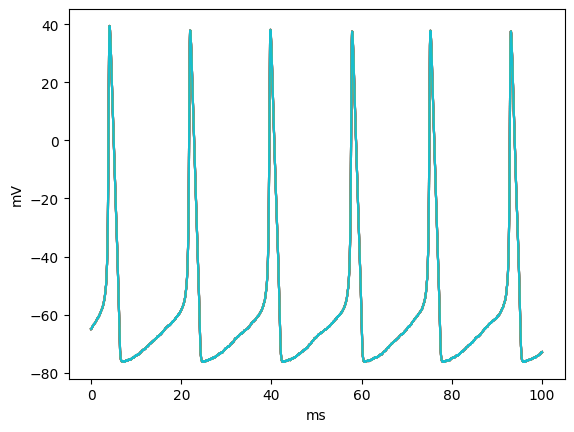

In [8]:
# Define the simulation times, from 0 to 100 ms with a time step of 'dt'
times = u.math.arange(0. * u.ms, 100. * u.ms, dt)

# Run the simulation using `brainstate.transform.for_loop`:
# - `run` function is called iteratively with each time step and random input current
# - Random input current between 1 and 10 uA/cm² is generated at each time step
# - `pbar` is used to show a progress bar during the simulation
vs = brainstate.transform.for_loop(
    run,
    times,  # Time steps as input
    brainstate.random.uniform(1., 10., times.shape) * u.uA / u.cm ** 2,  # Random input current (1 to 10 uA/cm²)
    pbar=brainstate.transform.ProgressBar(count=10)
)  # Show progress bar with 10 steps

# Plot the membrane potential over time
plt.plot(times, vs)
plt.show()  # Display the plot

# Simulation of Spiking Neural Network Models

One of the goals of neuroscience research is to uncover the possible principles by which the brain encodes information. As a potential encoding rule, we naturally expect neurons to produce the same response to the same stimulus. However, in the 1980s and 1990s, numerous experiments found that when the same external stimulus is presented repeatedly, the spike sequences produced by neurons in the cerebral cortex are different each time, and the spike sequences exhibit highly irregular statistical behaviors. Van Vreeswijk and Haim Sompolinsky proposed the **Excitatory-Inhibitory Balanced Network (E-I balanced network)**. They suggested that there should be both excitatory and inhibitory neurons in the network, and the inputs to both types of neurons must be balanced and counteracting. In this case, the mean input received by the neurons remains very small, and the variance (fluctuation) is large enough to induce irregular firing of neurons. Furthermore, the following conditions must also hold for the network:
+ Neuron connections are random and sparse, which reduces the statistical correlation between the internal inputs received by different neurons, leading to stronger macroscopic irregularity.
+ Statistically, the excitatory inputs and inhibitory inputs received by a neuron should approximately cancel each other out, meaning that the excitation and inhibition transmitted within the network are balanced.
+ The connection strength between neurons within the network is relatively strong, so the activity of the entire network is dominated not by external inputs but by synaptic currents generated by the internal network connections. The random fluctuations in synaptic currents determine the irregular firing of neurons.

<center>
    <img src="./_static/snn-simulation1.png" alt="EI-balance" />
</center>

Here, we simulate the Excitatory-Inhibitory Balanced Network model as an example of simulating a spiking neural network model.


In [9]:
import brainunit as u
import brainstate as brainstate
import matplotlib.pyplot as plt

## Defining Spiking Neural Network Model

We can use ``brainstate`` to define custom neuron models. To define a custom neuron model, we need to inherit the base class ``brainstate.nn.DynamicsGroup``.

1. First, define the initialization method ``__init__()``, which receives model parameters and initializes the model. Note that we need to first call ``super().__init__()`` to initialize the base class. The model initialization mainly includes initializing neurons and synapses:
   - **Initializing Neurons**: Neurons in the network can either use the pre-defined neuron models in ``brainstate.nn`` or use the custom neurons defined in the **Single Neuron Model Definition** section.
   - **Initializing Synapses**: Here, we use ``brainstate.nn.AlignPostProj``, which is suitable for the align-post projection model. In the align-post projection, the dimensions of the synaptic variables and the postsynaptic neuron group are the same. The update order of align-post projection models is: action potential → synaptic communication → synaptic dynamics → output. The update order of align-pre projection models is: action potential → synaptic dynamics → synaptic communication → output. Several parameters need to be set:
     - ``comm``: Describes the connections between the neuron groups.
     - ``syn``: Specifies which synapse model is used.
     - ``out``: Indicates whether the output is based on conductance or current.
     - ``post``: Specifies the postsynaptic neuron group.

2. Next, define the ``update()`` method, which receives the input for each time step and updates the model's current state. As a neuron network, neurons need to receive inputs not only from external sources but also from other neurons. Therefore, in this model, we first compute the inputs received from other neurons, then calculate the external inputs. Finally, we output the firing state of each neuron in the entire network.

In [10]:
class EINet(brainstate.nn.DynamicsGroup):
    def __init__(self, n_exc, n_inh, prob, JE, JI):
        # Initialize the network with the following parameters:
        # - n_exc: number of excitatory neurons
        # - n_inh: number of inhibitory neurons
        # - prob: connection probability between neurons
        # - JE: synaptic weight for excitatory connections
        # - JI: synaptic weight for inhibitory connections
        super().__init__()

        self.n_exc = n_exc  # Number of excitatory neurons
        self.n_inh = n_inh  # Number of inhibitory neurons
        self.num = n_exc + n_inh  # Total number of neurons (excitatory + inhibitory)

        # Initialize the neurons as LIF (Leaky Integrate-and-Fire) neurons
        self.N = brainstate.nn.LIF(
            n_exc + n_inh,  # Total number of neurons
            V_rest=-52. * u.mV,  # Resting potential (mV)
            V_th=-50. * u.mV,  # Threshold potential for firing (mV)
            V_reset=-60. * u.mV,  # Reset potential after spike (mV)
            tau=10. * u.ms,  # Membrane time constant (ms)
            V_initializer=brainstate.nn.Normal(-60., 10., unit=u.mV),
            # Initialize membrane potential with a normal distribution
            spk_reset='soft'  # Soft reset for spiking (reset without forcing a specific value)
        )

        # Synapse connections from excitatory neurons to all neurons
        self.E = brainstate.nn.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(n_exc, self.num, prob, JE),
            # Fixed probability of synaptic connection with strength JE
            syn=brainstate.nn.Expon.desc(self.num, tau=2. * u.ms),  # Exponential decay of synaptic weight
            out=brainstate.nn.CUBA.desc(),  # CUBA (Conductance-based) synaptic model
            post=self.N,  # Target neurons for these excitatory synapses
        )

        # Synapse connections from inhibitory neurons to all neurons
        self.I = brainstate.nn.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(n_inh, self.num, prob, JI),
            # Fixed probability of synaptic connection with strength JI
            syn=brainstate.nn.Expon.desc(self.num, tau=2. * u.ms),  # Exponential decay of synaptic weight
            out=brainstate.nn.CUBA.desc(),  # CUBA (Conductance-based) synaptic model
            post=self.N,  # Target neurons for these inhibitory synapses
        )

    def update(self, inp):
        # Get the spike states of the neurons
        spks = self.N.get_spike() != 0.  # Non-zero spikes (spike detection)

        # Update the synaptic currents for excitatory and inhibitory neurons
        self.E(spks[:self.n_exc])  # Apply excitatory synaptic input based on the excitatory neuron spikes
        self.I(spks[self.n_exc:])  # Apply inhibitory synaptic input based on the inhibitory neuron spikes

        # Update the neurons with the provided input current (inp)
        self.N(inp)

        # Return the spike states of the neurons (whether each neuron spiked)
        return self.N.get_spike()

## Running the Simulation Experiment

Set some model parameters. In this example, we use the sign (positive or negative) of the connection strength to set the excitatory or inhibitory nature of the neurons.

In [11]:
# connectivity
num_exc = 500
num_inh = 500
prob = 0.1
# external current
Ib = 3. * u.mA
# excitatory and inhibitory synaptic weights
JE = 1 / u.math.sqrt(prob * num_exc) * u.mS
JI = -1 / u.math.sqrt(prob * num_inh) * u.mS

Define the time step ``dt`` for the simulation.

After instantiating the defined model, initialize the instance with ``bst.nn.init_all_states()``.

In [12]:
# network
brainstate.environ.set(dt=0.1 * u.ms)
net = EINet(num_exc, num_inh, prob=prob, JE=JE, JI=JI)
_ = brainstate.nn.init_all_states(net)

EINet(
  layers_tuple=(),
  layers_dict={},
  n_exc=500,
  n_inh=500,
  num=1000,
  N=LIF(
    in_size=(1000,),
    out_size=(1000,),
    current_inputs={'AlignPostProj0': CUBA(
      scale=volt
    )},
    before_updates={"(<class 'brainstate.nn.Expon'>, (1000,), {'tau': 2. * msecond}) // (<class 'brainstate.nn.CUBA'>, (), {})": _AlignPost(
      syn=Expon(
        in_size=(1000,),
        out_size=(1000,),
        tau=2. * msecond,
        g_initializer=ZeroInit(
          unit=msiemens
        ),
        g=HiddenState(
          value=ArrayImpl([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0., 0., 0., 0.... * msiemens
        )
      ),
      out=CUBA(...)
    )},
    spk_reset='soft',
    spk_fun=ReluGrad(alpha=0.3, width=1.0),
    R=1. * ohm,
    tau=10. * msecond,
    V_th=-50. * mvolt,
    V_rest=-52. * mvolt,
    V_reset=-60. * mvolt,
    V_initializer=Normal(
      scale=10.0,
      mean=-60.0,
      rng=RandomState([2647944946 193937729

The instantiated network model uses the ``update()`` method to input the current for each time step.

Use ``bst.compile.for_loop()`` to iterate the function and run the simulation for a certain period of time. The first argument is the function to iterate, followed by the parameters that the function requires. You can also display a progress bar during the iteration.

This completes the simulation of the spiking neural network model.

In [13]:
# Simulation
# Define the time array from 0 to 1000 ms with a step size of dt
times = u.math.arange(0. * u.ms, 1000. * u.ms, brainstate.environ.get_dt())

# Run the simulation using `brainstate.transform.for_loop`, iterating over each time step
# The `lambda t: net.update(Ib)` applies the `update` method of the network `net`
# for each time step, with `Ib` as the input current at each time step.
spikes = brainstate.transform.for_loop(
    lambda t: net.update(Ib),  # Call net.update with input current Ib
    times,  # Time steps
    pbar=brainstate.transform.ProgressBar(10)  # Show a progress bar with 10 steps
)

2024-12-15 18:46:36.710433: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse the raw backend config str.
2024-12-15 18:46:36.710492: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse the raw backend config str.
2024-12-15 18:46:36.710519: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse the raw backend config str.


  0%|          | 0/10000 [00:00<?, ?it/s]

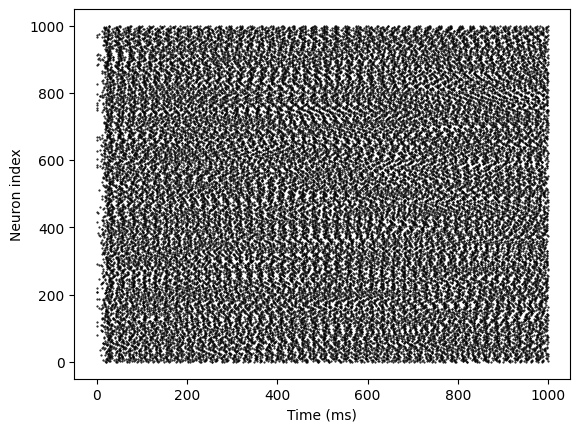

In [14]:
# visualization
times = times.to_decimal(u.ms)
t_indices, n_indices = u.math.where(spikes)
plt.plot(times[t_indices], n_indices, 'k.', markersize=1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.show()